In [1]:
import os
import time
import tqdm
import random
from tqdm.notebook import tqdm
import seaborn as sns

import numpy as np
import pandas as pd
import audb
import audiofile
from scipy.io.wavfile import read as read_wav
from matplotlib import pyplot as plt
import opensmile

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split #train/test split 
from sklearn.svm import SVC #Model
from sklearn.metrics import confusion_matrix #Metrics 
from sklearn.metrics import f1_score 
from sklearn.model_selection import cross_val_score #Cross-validation
from sklearn.model_selection import KFold

import scipy
import random #for shuffling values 
from scipy import stats

#List of prosodic features we will observe

features_prosody= ['Loudness_sma3', 
                   'hammarbergIndex_sma3',
                   'F0semitoneFrom27.5Hz_sma3nz',
                   'jitterLocal_sma3nz',
 'shimmerLocaldB_sma3nz',
 'HNRdBACF_sma3nz']


#Gets low-level features of all audios 
def lowlevel_features(list_with_files, dir_path):
    
    path = dir_path
    #  Define feature extractor
    smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )

    df_data= []

    for i in tqdm((list_with_files)):
        f= path + i
        sampling_rate, data = read_wav(f) #gets sampling rate and dimensions of data
        #print(f"Sampling rate of {f}:{sampling_rate}")
        
        db = audb.load('emodb',
        version='1.1.1',
        format='wav',
        mixdown=True,
        sampling_rate=sampling_rate,
        media='wav/03a01.*',  # load subset
        full_path=False,
        verbose=False,)

        #extract features
        signal, sampling_rate = audiofile.read(f, duration=120, always_2d=True)
        data= smile.process_signal(signal, sampling_rate)
        df= data.loc[:,features_prosody]
        # Select the column you want to normalize
        column_to_normalize = 'F0semitoneFrom27.5Hz_sma3nz'
        # Extract the column as a numpy array
        column_data = df[column_to_normalize].values.reshape(-1, 1)
        # Normalize the column
        scaler = StandardScaler()
        normalized_column = scaler.fit_transform(column_data)
        # Replace the original column with the normalized values
        df[column_to_normalize] = normalized_column
        df_data.append(df.values)

   # df= pd.concat(df_data, ignore_index=True)
    return df_data



In [2]:
#Read all labels 

labels= open('labels_extension.txt', 'r').read().split('\n')
labels= [int(label) for label in labels if label]

In [3]:
#Process wav files 
path="audios/"
dir_list = os.listdir(path)
feature_data= lowlevel_features(dir_list, path)

  0%|          | 0/541 [00:00<?, ?it/s]

In [4]:
# Find the shape of the largest matrix
max_shape = max(matrix.shape for matrix in feature_data)

# Zero-pad the rows of matrices
padded_matrices = []
for matrix in feature_data:
    pad_width = ((0, max_shape[0] - matrix.shape[0]), (0, 0))
    padded_matrix = np.pad(matrix, pad_width, mode='constant', constant_values=0)
    padded_matrices.append(padded_matrix)

In [5]:
#Train/Test split 
y= labels
#y= y_axis.to_numpy().flatten() #Labels (class 0 and 1)
X = np.asarray(padded_matrices)
X= X.reshape(-1, X.shape[1]*X.shape[2])
#X= X_axis.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
#Cross-validation (Overfitting)

C_list= np.logspace(-5, 5, 20)
gamma_list= np.logspace(-8, -5, 20)
recall = np.zeros((len(C_list), len(gamma_list)))
precision = np.zeros((len(C_list), len(gamma_list)))

for i in tqdm(range(len(C_list))):
     for j in range(len(gamma_list)):
         svc= SVC(C=C_list[i], gamma=gamma_list[j], kernel='rbf')
         svc.fit(X_train, y_train)
         y_pred= svc.predict(X_train)
         tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
         recall[i, j] = float(tp) / (tp + fn)
         precision[i,j]= float(tp + tn) / (tp + tn + fp + fn)
               

index_max = np.unravel_index(np.argmax(precision), recall.shape)

print('Max. precision:{}'.format(precision[index_max]))
C_opt = C_list[index_max[0]]
gamma_opt = gamma_list[index_max[1]]
print('Optimal C: {}'.format(C_opt))
print('Optimal gamma:{}'.format(gamma_opt))


  0%|          | 0/20 [00:00<?, ?it/s]

Max. precision:1.0
Optimal C: 1.8329807108324339
Optimal gamma:2.335721469090121e-06


In [8]:
#Optimal hyperparameters for overfitting 
C_opt_of=1.8329807108324339
gamma_opt_of=2.335721469090121e-06

In [9]:
svc= SVC(C=C_opt_of, gamma=gamma_opt_of, kernel='rbf')
svc.fit(X_train, y_train)
y_pred= svc.predict(X_train)
cm= confusion_matrix(y_train, y_pred)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
recall = float(tp) / (tp + fn)
precision= float(tp + tn) / (tp + fn + fp + tn)

print('Recall: {}'.format(recall)) 
print('Precision {}'.format(precision))
cm

Recall: 0.9934640522875817
Precision 0.9971014492753624


array([[192,   0],
       [  1, 152]])

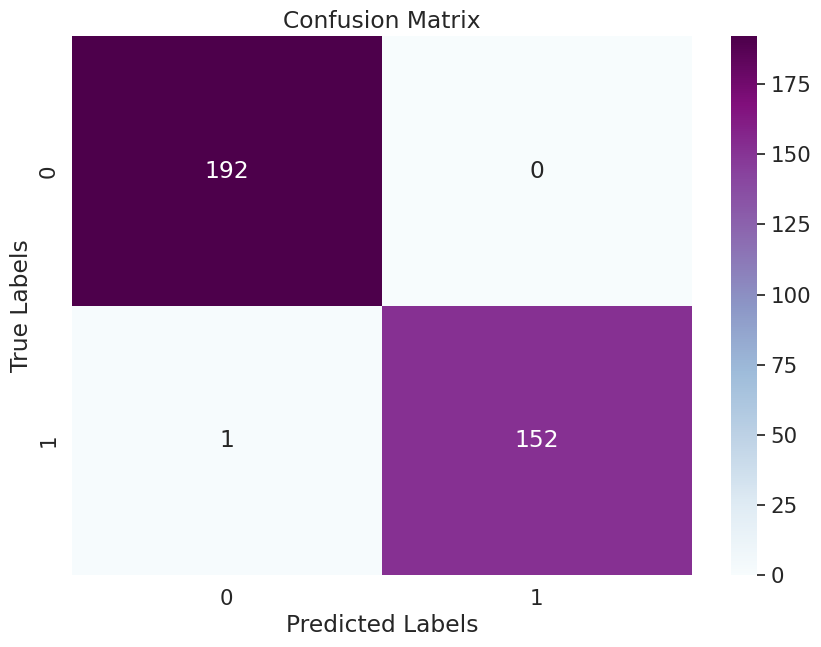

In [11]:
#Displaying result of Overfitting 

plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='d', cmap="BuPu")

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the confusion matrix as an image
plt.savefig('SVM_overfitting_matrix.png')

# Display the plot
plt.show()

In [9]:
#Validation of model 

kf = KFold(n_splits=10, shuffle=True)
recall_scores = []
precision_scores=[]
for train_idx, val_idx in kf.split(X):
    X_train_k, y_train_k = X[train_idx, :], np.asarray(y)[train_idx]
    X_val_k, y_val_k = X[val_idx, :], np.asarray(y)[val_idx]
    svc= SVC(C=C_opt_of, gamma=gamma_opt_of, kernel='rbf', class_weight='balanced')
    svc.fit(X_train_k, y_train_k)
    y_pred_k= svc.predict(X_val_k)
    cm= confusion_matrix(y_val_k, y_pred_k)
    tn, fp, fn, tp = confusion_matrix(y_val_k, y_pred_k).ravel()
    recall_v = float(tp) / (tp + fn)
    precision_v= float(tp + tn) / (tp + fn + fp + tn)
    recall_scores.append(recall_v)
    precision_scores.append(precision_v)

print('Recall mean: {}'.format(np.mean(recall_scores))) 
print('Recall standard deviation: {}'.format(np.std(recall_scores)))
print('Precision mean: {}'.format(np.mean(precision_scores))) 
print('Precision standard deviation: {}'.format(np.std(precision_scores)))

Recall mean: 0.36708948700253047
Recall standard deviation: 0.12478633266870433
Precision mean: 0.5195286195286195
Precision standard deviation: 0.07898189011040248


In [ ]:
#Cross-validation (classifier)

C_list= np.logspace(-5, 5, 20)
gamma_list= np.logspace(-8, -5)
recall = np.zeros((len(C_list), len(gamma_list)))
precision = np.zeros((len(C_list), len(gamma_list)))

for i in tqdm(range(len(C_list))):
     for j in range(len(gamma_list)):
        svc= SVC(C=C_list[i], gamma=gamma_list[j], kernel='rbf')
        svc.fit(X_train, y_train)
        y_pred= svc.predict(X_train)
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
        recall[i, j] = float(tp) / (tp + fn)
        precision[i,j]= float(tp + tn) / (tp + tn + fp + fn)
               

index_max = np.unravel_index(np.argmax(recall), recall.shape)

print('Max. recall:{}'.format(recall[index_max]))
C_opt = C_list[index_max[0]]
gamma_opt = gamma_list[index_max[1]]
print('Optimal C: {}'.format(C_opt))
print('Optimal gamma:{}'.format(gamma_opt))


  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
#Optimal parameters from Classifier implementation
C_opt= 20.6913808111479
gamma_opt= 2.2229964825261955e-07

In [13]:
#Validation of model 

kf = KFold(n_splits=10, shuffle=True)
recall_scores = []
precision_scores=[]
for train_idx, val_idx in kf.split(X):
    X_train_k, y_train_k = X[train_idx, :], np.asarray(y)[train_idx]
    X_val_k, y_val_k = X[val_idx, :], np.asarray(y)[val_idx]
    svc= SVC(C=C_opt, gamma=gamma_opt, kernel='rbf', class_weight='balanced')
    svc.fit(X_train_k, y_train_k)
    y_pred_k= svc.predict(X_val_k)
    cm= confusion_matrix(y_val_k, y_pred_k)
    tn, fp, fn, tp = confusion_matrix(y_val_k, y_pred_k).ravel()
    recall_v = float(tp) / (tp + fn)
    precision_v= float(tp + tn) / (tp + fn + fp + tn)
    recall_scores.append(recall_v)
    precision_scores.append(precision_v)

print('Recall mean: {}'.format(np.mean(recall_scores))) 
print('Recall standard deviation: {}'.format(np.std(recall_scores)))
print('Precision mean: {}'.format(np.mean(precision_scores))) 
print('Precision standard deviation: {}'.format(np.std(precision_scores)))


Recall mean: 0.41184487734487735
Recall standard deviation: 0.10260885819442757
Precision mean: 0.4805050505050505
Precision standard deviation: 0.09279359267006085


In [16]:
svc= SVC(kernel='rbf', class_weight='balanced', C=C_opt, gamma=gamma_opt)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
cm= confusion_matrix(y_test, y_pred)

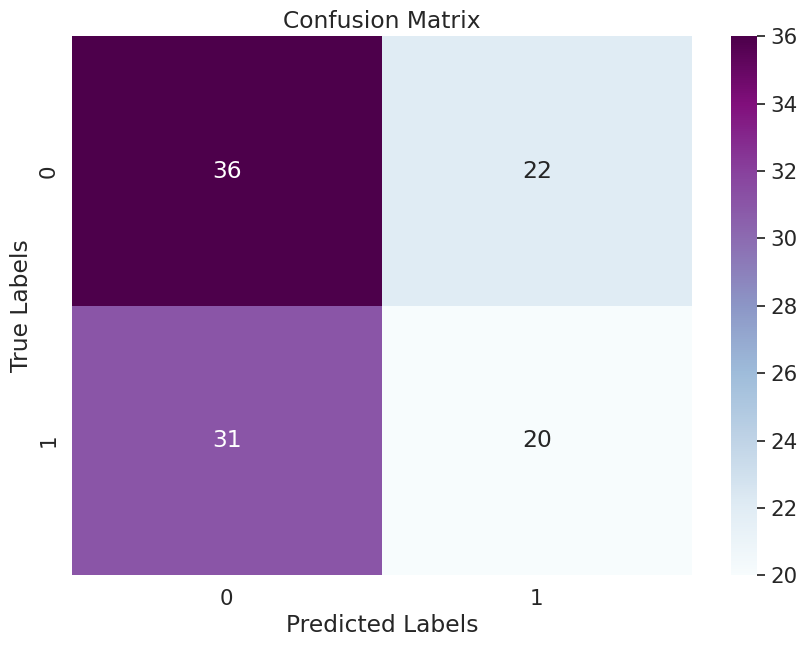

In [17]:
#Displaying result of Classifier

plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='d', cmap="BuPu")

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the confusion matrix as an image
plt.savefig('SVM_classifier_matrix.png')

# Display the plot
plt.show()